In [4]:
import numpy as np
import tensorflow as tf
import generateTimeseries
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow.experimental.numpy as tnp

### Parameters

In [36]:
## Network Parameters
nReservoir = 900
sparsity = 0.995 # 90 % of conncetions set to 0

sigma_in = 0.002 ## No need to touch this really?
sigma_res = 1/(2*nReservoir)

## Dataset Parameters
LengthTimeSeries = 10000
lengthTest = 1000

## SyncState declares how many datapoints are fed to allow the reservoir to sync
syncState = 4000

np.random.seed(2)

### Initiate Network

In [37]:
## Create trainingData
nTimeSeries = 1

lengthTraining = LengthTimeSeries - lengthTest

dataset = generateTimeseries.wrapper(nTimeSeries,LengthTimeSeries)
dataset = dataset[0,:,:]
# scaler = StandardScaler(with_mean=True,with_std=True).fit(dataset)
# dataset = scaler.transform(dataset)


## Discard 100 first
trainingData = dataset[100:lengthTraining]
testData = dataset[lengthTraining:LengthTimeSeries]

print(trainingData[lengthTraining-102])
print(trainingData[-1])
print(testData[0])

testData = np.insert(testData,0,np.reshape(trainingData[-1,:],(1,3)),axis=0)
print(testData.shape)

################


nInput = 3
nOutput = 3


## Input weights:
W_in = np.random.normal(0,scale=np.sqrt(sigma_in),size=(nInput,nReservoir))

## Reservoir :
W_res = np.random.normal(0,scale=np.sqrt(sigma_res),size=(nReservoir,nReservoir))
sparsityMask = np.random.choice([True,False],size=(nReservoir,nReservoir),p=[sparsity,1-sparsity])
W_res[sparsityMask] = 0


# SVD = TruncatedSVD(nReservoir).fit(W_res)
# maxSingular = np.max(np.abs(SVD.singular_values_))
# W_res = W_res/maxSingular

localField_res = np.zeros((1,nReservoir))

## Output Weights:
#W_out = np.random.uniform(-0.1,0.1,size=(nReservoir,nOutput))


#######################
## Print N, Sigma & sparsity
print("\n########################################################################")
print(f"Reference for input: N*sigma_in = 0.1 - 0.9\n")
print(f"N: {nInput}\t Sigma_in: {W_in.var()}\n\nN*Sigma_in: {nInput*W_in.var()}")
print("\n########################################################################")
print(f"Reference for input: N*sigma_res = 0.85 - 1.15\n")
print(f"N: {nReservoir}\t Sigma_res: {W_res.var()}\t Sparsity: {1-sparsity}\n\nN*sparsity*Sigma_res: {(1-sparsity)*nReservoir*W_res.var()}")

W_res = tnp.array(W_res)
localField_res = tnp.array(localField_res)


[ 0.48795922 -4.79259015  1.39729982]
[ 4.70788795  9.35563361 28.37623252]
[ 5.17266251  9.24436466 28.05998573]
[ 5.57983273  9.14881816 27.78989923]
(1001, 3)

########################################################################
Reference for input: N*sigma_in = 0.1 - 0.9

N: 3	 Sigma_in: 0.0020070608633143217

N*Sigma_in: 0.006021182589942965

########################################################################
Reference for input: N*sigma_res = 0.85 - 1.15

N: 900	 Sigma_res: 2.717034382046233e-06	 Sparsity: 0.0050000000000000044

N*sparsity*Sigma_res: 1.222665471920806e-05


### Train

In [38]:
## Train by first generating the output from the reservoir and then performing Ridge Regression on the output
reservoirOutput = []
counter = 0

for networkInput in trainingData:
    counter += 1

    input = tnp.matmul(networkInput,W_in)
    localField_res = tnp.tanh(input + tnp.matmul(localField_res,W_res))
    
    if counter > syncState:
        reservoirOutput.append(localField_res)


reservoirOutput = tnp.array(reservoirOutput)
reservoirOutput = np.delete(reservoirOutput,-1,axis=0) # delete last index

# Adjust Weights:
targets = np.roll(trainingData,-1,axis = 0)
targets = np.delete(targets,-1,axis=0) # delete last index

targets = targets[syncState:]
print(targets.shape)

####### Above takes long time

######################## Ridge Regression
alpha = 0.005

reservoirOutput = tnp.squeeze(reservoirOutput)
targets = tnp.squeeze(targets)


ridgeResult = Ridge(alpha)
ridgeResult.fit(reservoirOutput,targets)
print(ridgeResult.score(reservoirOutput,targets))
W_out = ridgeResult.coef_.T


# # print(ridgeResult.coef_.shape)
# print(targets.shape)
# print(reservoirOutput.shape)
# left = np.matmul(targets.T,reservoirOutput)
# print(left.shape)
# right = np.linalg.inv(np.matmul(reservoirOutput.T,reservoirOutput)-alpha*np.identity(nReservoir))
# ridgeResult = np.matmul(left,right)
# print(ridgeResult.shape)

# W_out = ridgeResult.T

# RANK 
rank = tnp.matmul(localField_res,tnp.transpose(localField_res))
print(rank)


(4899, 3)
0.9999992199721537
tf.Tensor([[459.00130329]], shape=(1, 1), dtype=float64)


(3,)


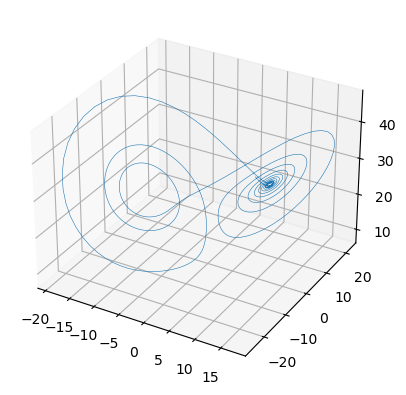

In [39]:
#generate 800 new points by feeding the last and then plotting
np.random.seed(2)
## Initialize
#localField_res = np.zeros((1,nReservoir))
#print(testData.shape)
#print(trainingData[-1].shape)

#print(testData[0,:])
#print(trainingData[-1,:])
networkInput = np.matmul(reservoirOutput[-1],W_out)
print(networkInput.shape)
#networkInput = np.reshape(trainingData[-1,:],(1,3))
outputs = []


# networkInput = np.matmul(reservoirOutput[-1,:],W_out)

for _ in range(lengthTest):
    input = np.matmul(networkInput,W_in)

    localField_res = np.tanh(input + np.matmul(localField_res,W_res))
    
    networkInput = np.matmul(localField_res,W_out)
    #print(networkInput.shape)
    outputs.append(networkInput)


### Plot

outputs = np.squeeze(np.array(outputs))

ax = plt.figure().add_subplot(projection="3d")
ax.plot(outputs[0:lengthTest,0],outputs[0:lengthTest,1],outputs[0:lengthTest,2],lw=0.4)




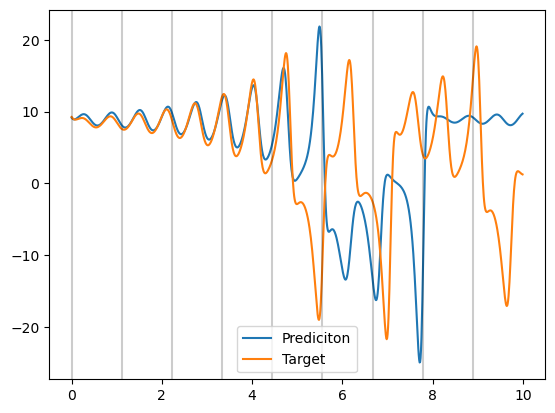

In [40]:
## Plot one variable
lyapunovExponent = 0.9
lyapunovTimes = np.arange(0,10,1/lyapunovExponent)

xTime = np.arange(0,10,0.01)

plt.plot(xTime,outputs[0:lengthTest,1],label="Prediciton")
plt.plot(xTime,testData[0:lengthTest,1],label="Target")
for lyapunovTime in lyapunovTimes:
    plt.axvline(lyapunovTime,color="black",alpha=0.2)


plt.legend()

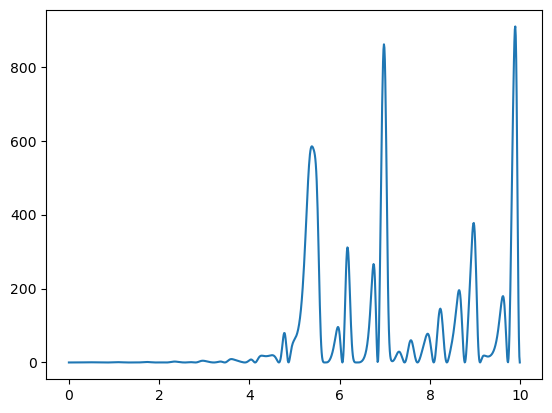

In [29]:
# Plot Squared Error Distance Between Pred & Target
squaredError = (outputs[0:lengthTest,1] - testData[0:lengthTest,1])**2
plt.plot(xTime,squaredError)

In [ ]:
# Take 1 sequence and plot
ax = plt.figure().add_subplot(projection="3d")
ax.plot(trainingData[:,0],trainingData[:,1],trainingData[:,2],lw=0.4)
ax.plot(testData[:,0],testData[:,1],testData[:,2],lw=0.4)